# Sythetic LEGO Image Data Classification Analysis

## About Project Presenter

- Kaan Can
- cank19@itu.edu.tr 
- 090190311

## Table of Content

- [1. Data Set Introduction](#1.-Data-Set-Introduction)
- [2. Description of the Problem](#2.-Description-of-the-Problem)
- [3. Feature Extraction](#3.-Feature-Extraction)
- [4. Exploratory Data Analysis](#4.-Exploratory-Data-Analysis)
    - [4.1. Target Analysis](#4.1.-Target-Analysis)
    - [4.2. Split Dataset into Train and Test](#4.2.-Split-Dataset-into-Train-and-Test)
    - [4.3. Missing Values Analysis](#4.3.-Missing-Values-Analysis)
    - [4.4. Outliers Analysis](#4.4.-Outliers-Analysis)
        - [4.4.1. Visualize Outliers](#4.4.1.-Visualize-Outliers)
- [5. Feature Analysis](#5.-Feature-Analysis)
- [6. Modeling Process](#6.-Modeling-Process)
    - [6.1. Logistic Regression](#6.1.-Logistic-Regression)
        - [6.1.1. Visualize Results](#6.1.1.-Visualize-Results)
    - [6.2. K-Nearest Neighbors](#6.2.-K-Nearest-Neighbors)
        - [6.2.1. Visualize Results](#6.2.1.-Visualize-Results)
- [7. Conclusion](#7.-Conclusion)
- [References](#References)

## 1. Data Set Introduction

- The synthetic [dataset](https://www.kaggle.com/joosthazelzet/lego-brick-images) has 50 different LEGO bricks images rendered by 800 different angles.
- I randomly selected 7 LEGO pieces from the dataset and used all 800 images for each LEGO piece. There is 5600 images in total.
- There is no numerical, nominal, ordinal features along with the dataset. Only images. 

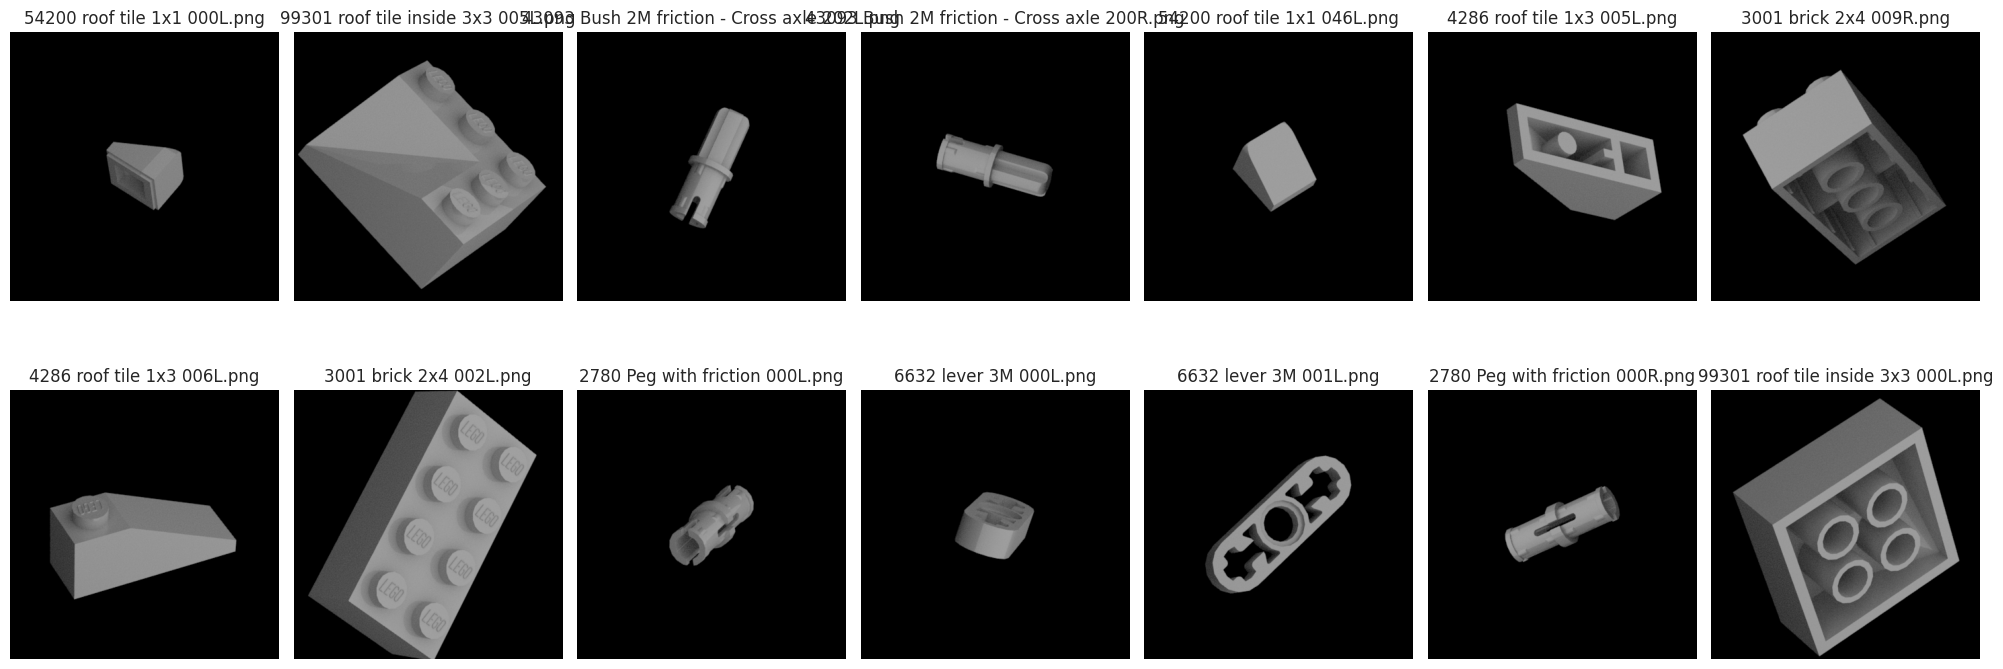

In [141]:
# Import sample datasets & show them from sample_of_raw_dataset folder
import matplotlib.pyplot as plt
import os
from PIL import Image

# Read images
directory_path = 'sample_of_raw_dataset'
image_files = [os.path.join(directory_path, file) for file in os.listdir(directory_path) if file.endswith('.png')]
image_files = image_files[:14]

#Plote images
fig, axes = plt.subplots(nrows=2, ncols=7, figsize=(20, 8))

for ax, image_file in zip(axes.flatten(), image_files):

    image = Image.open(image_file)
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(os.path.basename(image_file))

plt.tight_layout()
plt.show()

## 2. Description of the Problem

- As ı mentioned here is no numerical, nominal, ordinal features along with the dataset, only images. 
    So deep learning algorithms such as CNN can be usefull for this classification problem. But I will try to use machine learning algorithms for this problem.
- The aim of the project is extract features from images and classify them using machine learning algorithms.
- I will use image processing techniques to extract features from images and use these features to do multi-class classification.


## 3. Feature Extraction

- I used image processing techniques from [scikit - image]("https://scikit-image.org/") and [OpenCV]("https://opencv.org/") to extract features from images on other notebook.
- I created a new dataset with extracted 7 features and 1 target variable than saved it as csv file.

Here is the features that I extracted from images:
* **CODE**: Name of the LEGO pieces (Target Variable)
* **SHAPE**: Detected shape of the LEGO piece
* **AREA**: Calculated area of the LEGO piece shape
* **SCORE**: Pixel length of the longest line detected in the LEGO piece
* **PERCENT**: The comparability ratio between longest line and original image
* **CIRCLES**: Number of circles detected in the LEGO piece
* **NUM_OF_LINES**: Number of corectly detected lines in the LEGO piece
* **NUM_OF_CORNERS**: Number of corners detected in the LEGO piece
All features are numerical features. However, **SHAPE** feature is a can be considered as ordinal feature. Because it defines the shape of the LEGO piece. It will be examined in the later stages of the project.

In [142]:
# import dataset
import pandas as pd
import numpy as np
dataset = pd.read_csv('Synthetic_Data.csv')

In [143]:
# explore dataset
dataset.head()

,code,shape,area,score,percent,circles,num_lines,corners
0,2780,18,7415.0,77,19.25,2,0,39
1,2780,12,8439.5,68,17.00,0,0,34
2,2780,14,7019.5,66,16.50,3,0,39
3,2780,14,8599.5,68,17.00,0,0,37
4,2780,16,7835.0,100,25.00,4,1,39


## 4. Exploratory Data Analysis

### 4.1. Target Analysis

- There is 7 different LEGO pieces in the dataset.
- There is no missing values in the dataset. 
- There is no class imbalance problem in the dataset. All classes have same number of samples.

<Axes: xlabel='code'>

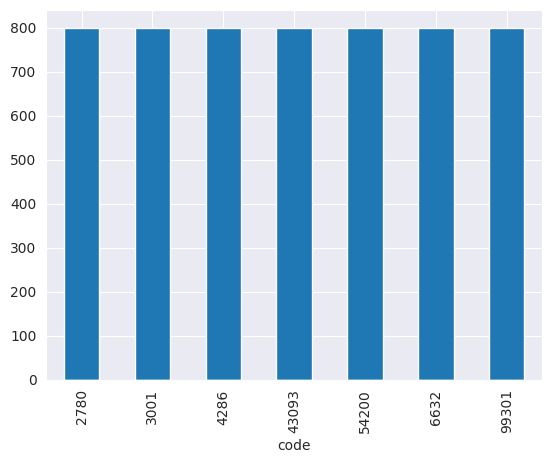

In [144]:
Target = dataset['code']
Features = dataset.drop(['code'], axis=1)

Target.value_counts()
Target.value_counts(normalize=True)
Target.value_counts().plot.bar()
Target.value_counts(normalize=True).plot.bar()

### 4.2. Split Dataset into Train and Test

- To avoid data leakage, I split dataset into train and test before data preprocessing.
- I used 80% of the dataset for training and 20% of the dataset for testing.

In [145]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(Features, Target, test_size=0.2, random_state=0)

### 4.3. Missing Values Analysis

- There is no Nan values in the dataset. However, there is 0 values in the dataset.

In [146]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5600 entries, 0 to 5599
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   code       5600 non-null   int64  
 1   shape      5600 non-null   int64  
 2   area       5600 non-null   float64
 3   score      5600 non-null   int64  
 4   percent    5600 non-null   float64
 5   circles    5600 non-null   int64  
 6   num_lines  5600 non-null   int64  
 7   corners    5600 non-null   int64  
dtypes: float64(2), int64(6)
memory usage: 350.1 KB


In [147]:
X_train = X_train.replace(0, np.nan)
X_test = X_test.replace(0, np.nan)

X_train.isnull().sum()

shape           0
area           15
score           0
percent         0
circles      1629
num_lines    2873
corners         0
dtype: int64

- I used KNN Imputer to impute missing values. This imputer uses k-nearest neighbors to impute missing values. It finds the most similar data point to the missing value and imputes the missing value with the value of the most similar data point. It is a good imputer for this dataset because it is a small dataset and it has 7 different classes. So it is easy to find the most similar data point.

In [148]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

X_train = pd.DataFrame(X_train, columns=Features.columns)
X_test = pd.DataFrame(X_test, columns=Features.columns)

X_train.isnull().sum()

shape        0
area         0
score        0
percent      0
circles      0
num_lines    0
corners      0
dtype: int64

### 4.4. Outliers Analysis

- There is same values can be considered as outliers in the dataset.
- First I checked the distribution of the features and plot boxplots to see outliers.
- Then I eliminated outliers using 3 standard deviation method.

In [149]:
X_train.describe()

,shape,area,score,percent,circles,num_lines,corners
count,4480.000000,4480.000000,4480.000000,4480.000000,4480.000000,4480.000000,4480.000000
mean,9.687946,24026.140759,90.363839,22.590960,2.964107,4.760937,40.532812
std,3.813518,21824.324664,43.096632,10.774158,2.383113,7.970271,24.335634
min,1.000000,0.500000,10.000000,2.500000,1.000000,1.000000,4.000000
25%,7.000000,8007.250000,60.000000,15.000000,1.000000,2.000000,23.000000
50%,9.000000,12464.250000,83.000000,20.750000,2.200000,4.000000,36.000000
75%,13.000000,38974.125000,114.000000,28.500000,3.800000,4.000000,56.000000
max,26.000000,79958.000000,328.000000,82.000000,25.000000,169.000000,155.000000


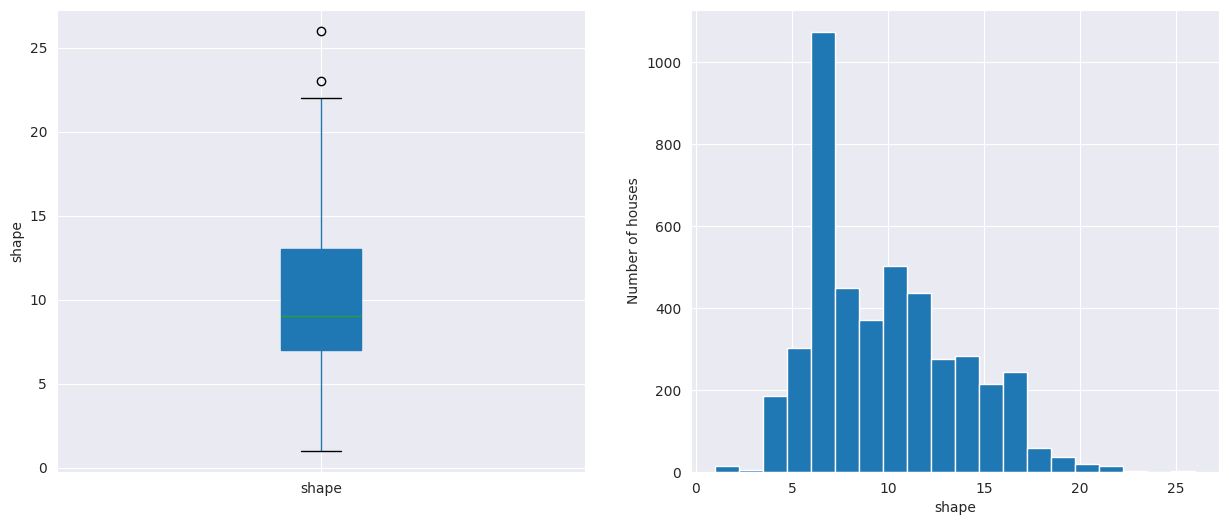

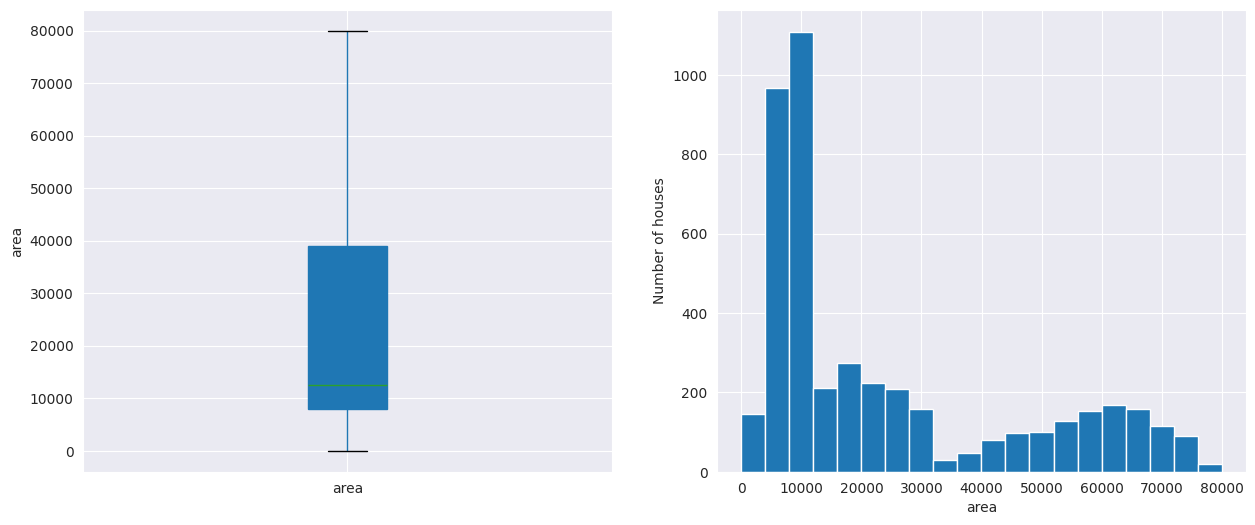

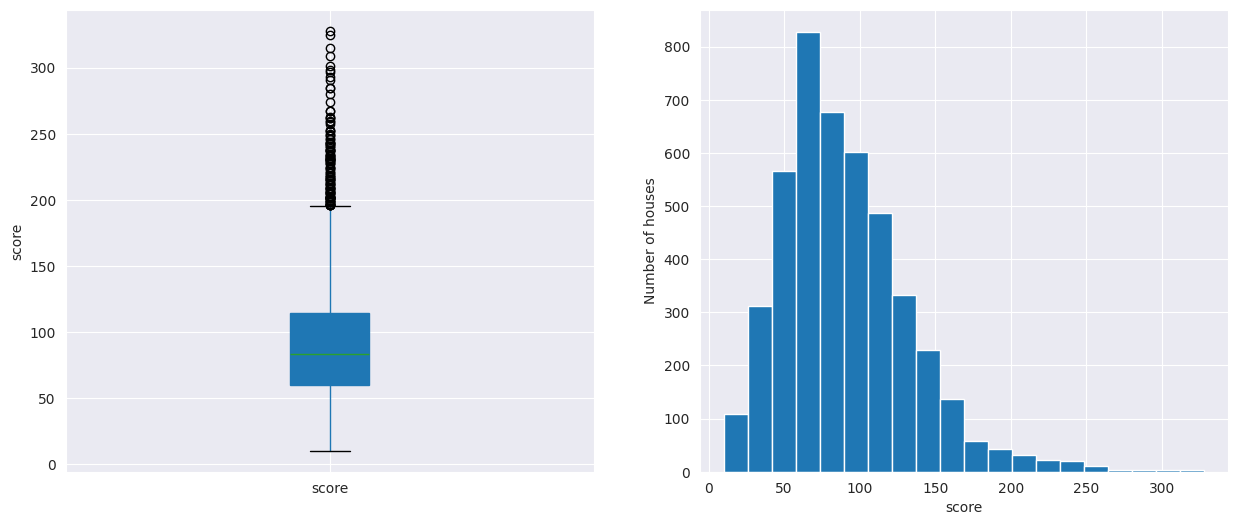

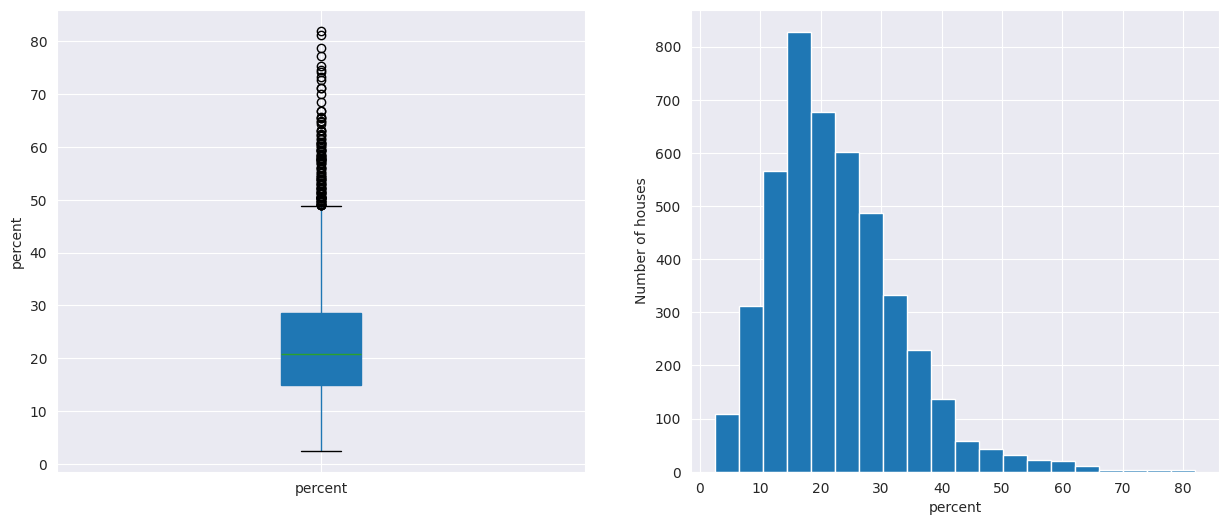

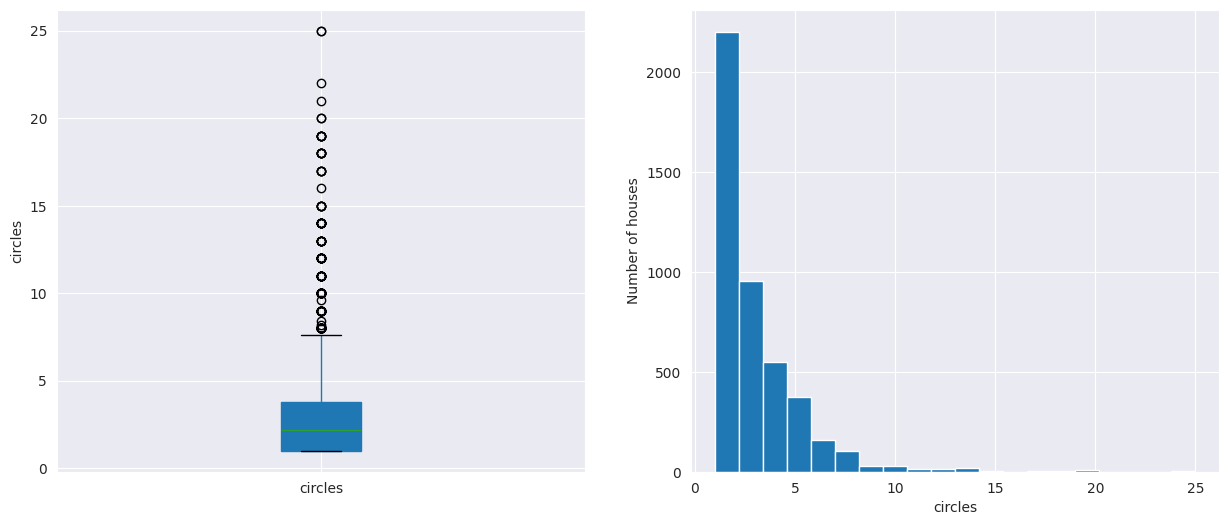

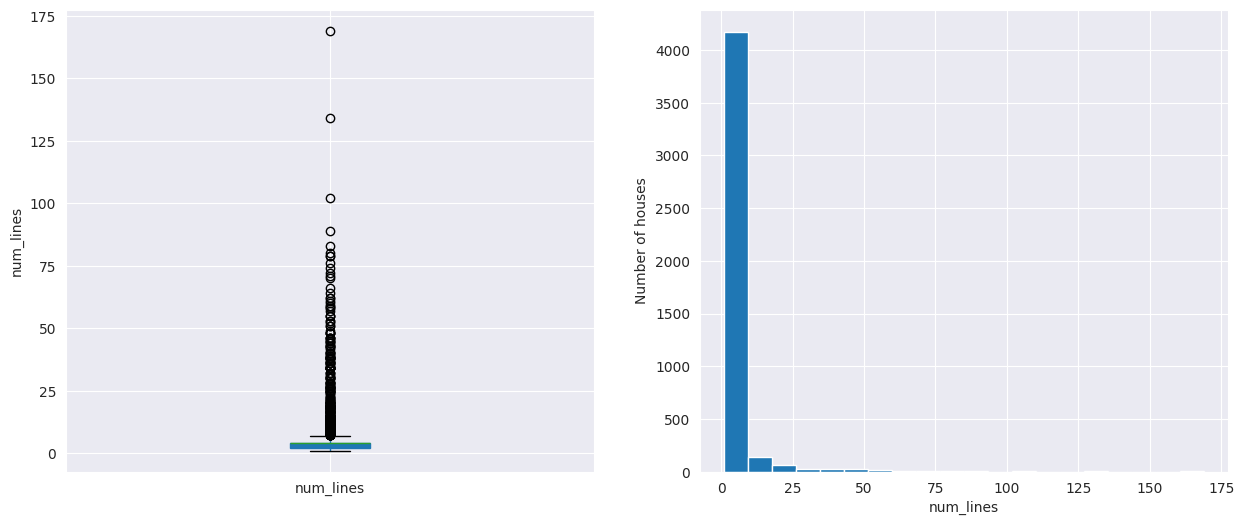

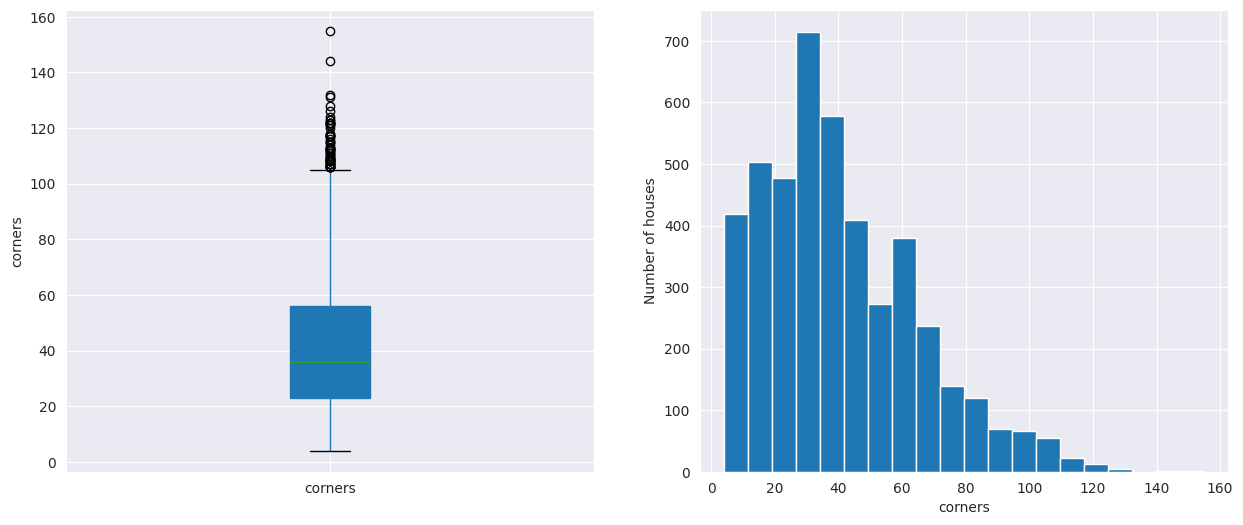

In [150]:
# Plot boxplots & histograms to see outliers
for var in X_train.columns:
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    fig = X_train.boxplot(column=var, patch_artist=True)
    fig.set_title('')
    fig.set_ylabel(var)

    plt.subplot(1, 2, 2)
    fig = X_train[var].hist(bins=20)
    fig.set_ylabel('Number of houses')
    fig.set_xlabel(var)

In [151]:
# Eliminate outliers 
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

for var in X_train.columns:
    upper_boundary = X_train[var].mean() + 3 * X_train[var].std()
    lower_boundary = X_train[var].mean() - 3 * X_train[var].std()
    print(var, upper_boundary, lower_boundary)
    print()

    train_outliers = X_train[(X_train[var] > upper_boundary) | (X_train[var] < lower_boundary)].index
    X_train = X_train.drop(index=train_outliers)
    y_train = y_train.drop(index=train_outliers)

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

X_train.describe()

shape 21.12850152664521 -1.7526086695023526

area 89491.81462913484 -41459.63764075235

score 219.47759541975574 -38.85471785049748

percent 50.80153428364528 -6.849946982057983

circles 9.895712330396673 -4.037377096645249

num_lines 22.477143786753068 -14.045972531503416

corners 106.82806896078598 -29.831862227737147


,shape,area,score,percent,circles,num_lines,corners
count,4182.000000,4182.000000,4182.000000,4182.000000,4182.000000,4182.000000,4182.000000
mean,9.855571,21930.512386,84.754663,21.188666,2.635533,3.562649,37.836681
std,3.768116,20299.078219,35.897547,8.974387,1.599273,2.610419,21.706140
min,1.000000,0.500000,10.000000,2.500000,1.000000,1.000000,4.000000
25%,7.000000,7929.625000,59.000000,14.750000,1.000000,2.000000,22.000000
50%,9.000000,9795.500000,80.000000,20.000000,2.000000,3.600000,34.000000
75%,13.000000,29030.125000,108.000000,27.000000,3.400000,4.000000,52.000000
max,21.000000,79958.000000,203.000000,50.750000,9.000000,22.000000,106.000000


### 5. Feature Analysis

- First I checked the categorical features. All features are labeled as numerical features. However, **SHAPE** feature is a can be considered as ordinal feature. Because it defines the shape of the LEGO piece. 
- We can compare the correlation analysis results between encoded and non-encoded **SHAPE** feature.

In [152]:
# check for categorical variables
categorical = [var for var in X_train.columns if X_train[var].dtype=='O']

print('There are {} categorical variables\n'.format(len(categorical)))
print('The categorical variables are :\n\n', categorical)

There are 0 categorical variables

The categorical variables are :

 []


# 5.1. Encoding Categorical Features

- I used one hot encoding to encode **SHAPE** feature.
- ı dropped one of the dummy variables to avoid dummy variable trap.

In [153]:
# encode categorical variables use one hot encoding
categorical_columns = ["shape"]

X_train = pd.get_dummies(X_train, columns=categorical_columns, drop_first=True)
X_test = pd.get_dummies(X_test, columns=categorical_columns, drop_first=True)

# update features names after encoding
Features = pd.get_dummies(Features, columns=categorical_columns, drop_first=True)
Features.drop(['shape_22', 'shape_23', 'shape_26'], axis=1, inplace=True)

X_train.head()

,area,score,percent,circles,num_lines,corners,shape_2.0,shape_3.0,shape_4.0,shape_5.0,...,shape_12.0,shape_13.0,shape_14.0,shape_15.0,shape_16.0,shape_17.0,shape_18.0,shape_19.0,shape_20.0,shape_21.0
0,48444.5,104.0,26.00,4.4,2.0,60.0,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
1,71868.5,127.0,31.75,6.0,3.0,69.0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,9264.0,98.0,24.50,2.6,2.8,32.0,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
3,8910.5,92.0,23.00,1.0,2.4,29.0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,7499.0,83.0,20.75,3.0,1.4,40.0,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False


In [154]:
Features

,area,score,percent,circles,num_lines,corners,shape_2,shape_3,shape_4,shape_5,...,shape_12,shape_13,shape_14,shape_15,shape_16,shape_17,shape_18,shape_19,shape_20,shape_21
0,7415.0,77,19.25,2,0,39,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
1,8439.5,68,17.00,0,0,34,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
2,7019.5,66,16.50,3,0,39,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
3,8599.5,68,17.00,0,0,37,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
4,7835.0,100,25.00,4,1,39,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5595,54816.5,77,19.25,0,0,63,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5596,39365.5,123,30.75,0,1,43,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5597,65092.0,71,17.75,0,0,62,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5598,73821.0,186,46.50,1,3,77,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### 5.2. Correlation Analysis

<Axes: >

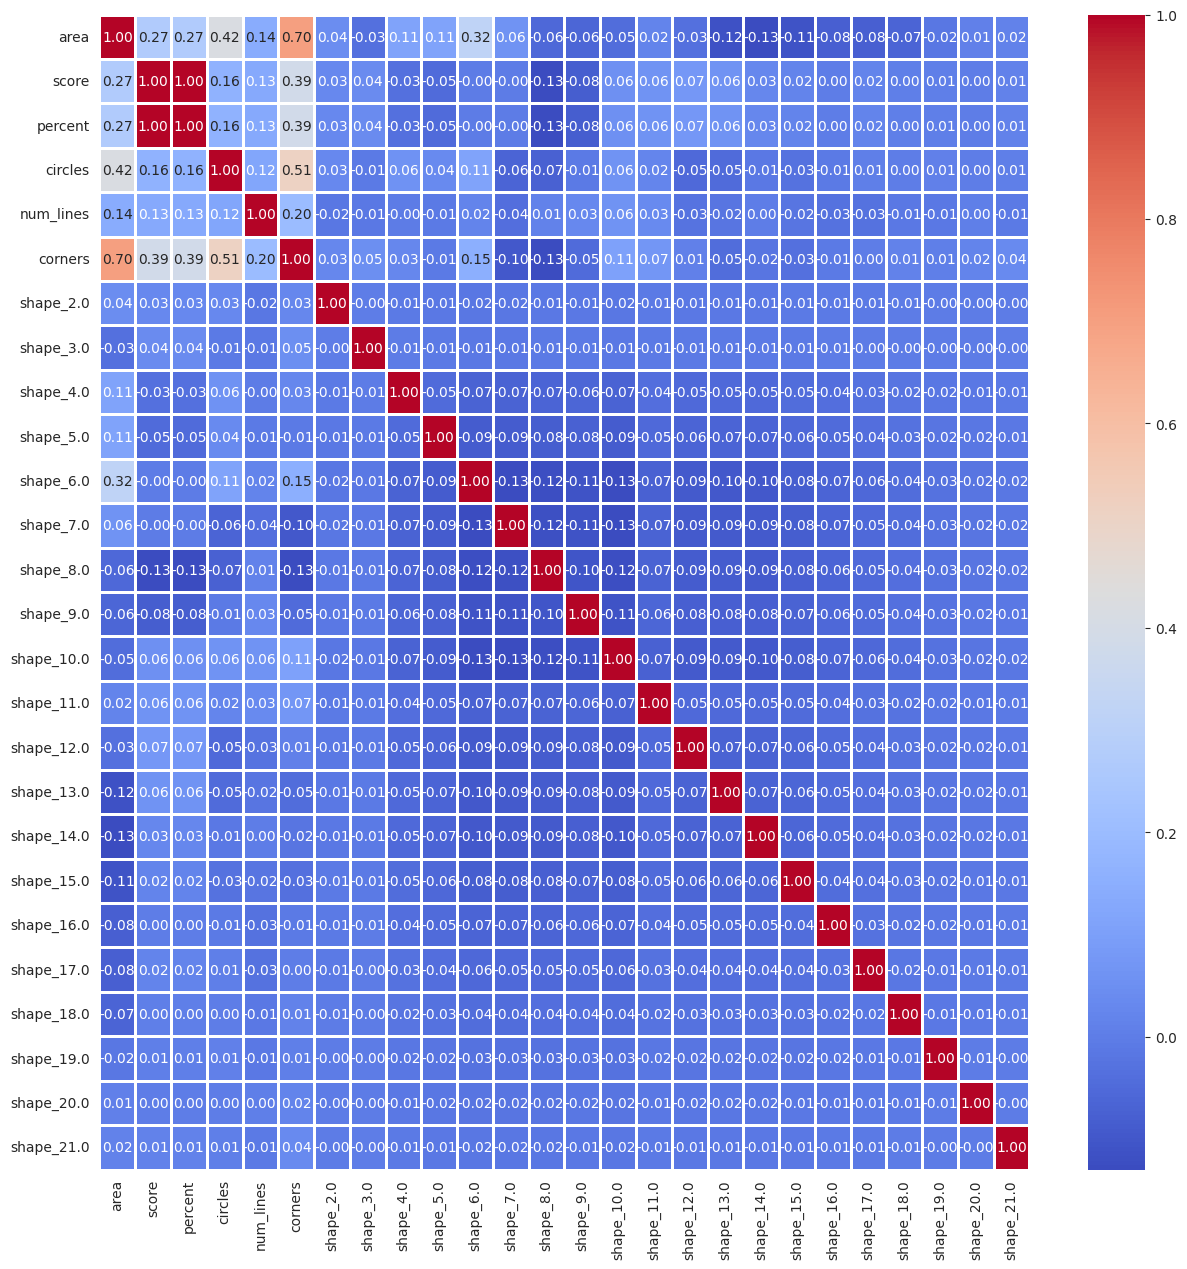

In [155]:
import seaborn as sns

plt.figure(figsize=(15,15))
sns.heatmap(X_train.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=2)

In [156]:
# eliminate highly correlated features
correlated_features = set()
correlation_matrix = X_train.corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
            
X_train.drop(labels=correlated_features, axis=1, inplace=True)
X_test.drop(labels=correlated_features, axis=1, inplace=True)

Features.drop(labels=correlated_features, axis=1, inplace=True)

X_train.head()

,area,score,circles,num_lines,corners,shape_2.0,shape_3.0,shape_4.0,shape_5.0,shape_6.0,...,shape_12.0,shape_13.0,shape_14.0,shape_15.0,shape_16.0,shape_17.0,shape_18.0,shape_19.0,shape_20.0,shape_21.0
0,48444.5,104.0,4.4,2.0,60.0,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
1,71868.5,127.0,6.0,3.0,69.0,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
2,9264.0,98.0,2.6,2.8,32.0,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
3,8910.5,92.0,1.0,2.4,29.0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,7499.0,83.0,3.0,1.4,40.0,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False


- I could use VIF to eliminate multicollinearity between features. But I used SelectKBest to find the feature importance and eliminated highly correlated features.

### 5.3. Feature Scaling

- I used MinMaxScaler to scale the features. Scaling will be helpfull for some machine learning algorithms.

In [157]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=Features.columns)
X_test = pd.DataFrame(X_test, columns=Features.columns)

X_train.head()

,area,score,circles,num_lines,corners,shape_2,shape_3,shape_4,shape_5,shape_6,...,shape_12,shape_13,shape_14,shape_15,shape_16,shape_17,shape_18,shape_19,shape_20,shape_21
0,0.605872,0.487047,0.425,0.047619,0.549020,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.898828,0.606218,0.625,0.095238,0.637255,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.115855,0.455959,0.200,0.085714,0.274510,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.111434,0.424870,0.000,0.066667,0.245098,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.093781,0.378238,0.250,0.019048,0.352941,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


# 5.4. Feature Importance

- I used Extra Trees Classifier to find the feature importance.
- Then selected most useful features to use in the model.

Total Features: 25
Selected Features: 15


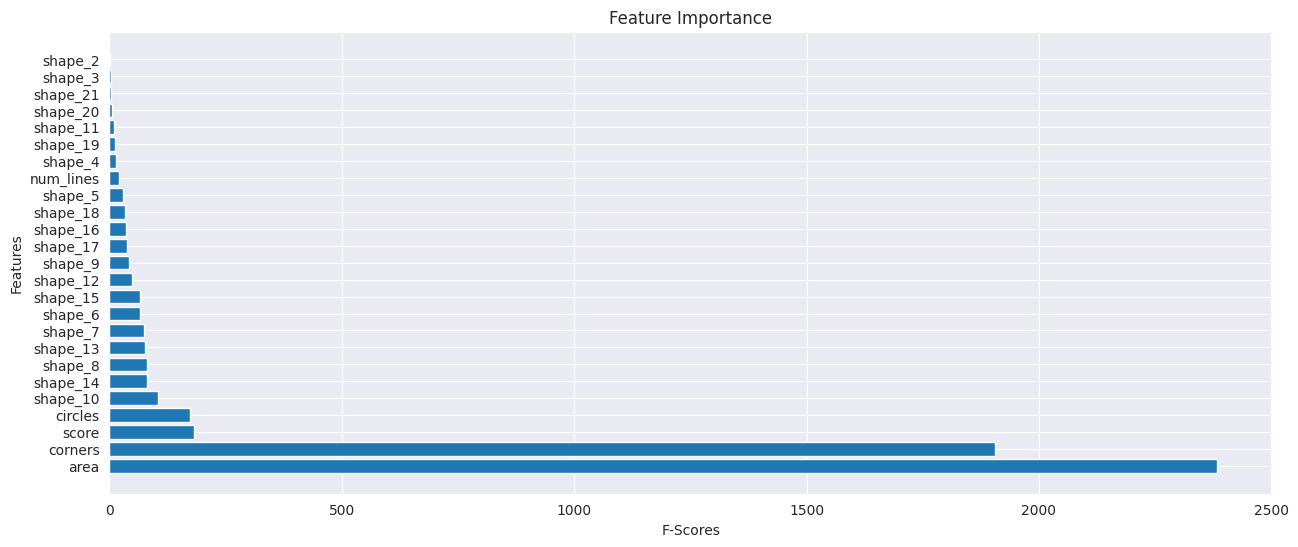

In [158]:
from sklearn.feature_selection import SelectKBest, f_classif

# find best features
selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)

# get selected features
selected_feat = X_train.columns[selector.get_support()]
print('Total Features: {}'.format((X_train.shape[1])))
print('Selected Features: {}'.format(len(selected_feat)))
selected_feat

# plot sorted feature importance
for i in range(len(selected_feat)):
    idx = np.argsort(selector.scores_)[::-1]
    X_train.columns[idx]
    
plt.figure(figsize=(15, 6))
plt.barh(X_train.columns[idx], selector.scores_[idx])
plt.title('Feature Importance')
plt.ylabel('Features')
plt.xlabel('F-Scores')
plt.show()

In [159]:
# update features
X_train = X_train[selected_feat]
X_test = X_test[selected_feat]
Features = Features[selected_feat]

X_train.head()

,area,score,circles,corners,shape_6,shape_7,shape_8,shape_9,shape_10,shape_12,shape_13,shape_14,shape_15,shape_16,shape_17
0,0.605872,0.487047,0.425,0.549020,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.898828,0.606218,0.625,0.637255,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.115855,0.455959,0.200,0.274510,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.111434,0.424870,0.000,0.245098,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.093781,0.378238,0.250,0.352941,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## 6. Modeling Process

- First I used Logistic Regression to classify the LEGO pieces.

### 6.1. Logistic Regression

In [160]:
# fit model
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# check performance & plot the results
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print('Accuracy Score: ', accuracy_score(y_train, model.predict(X_train)))

Accuracy Score:  0.8020086083213773


- In training set, model has 0.80 accuracy score and test set has 0.79 accuracy score. There is no overfitting problem.

In [161]:
# predict test set
y_pred = model.predict(X_test)

# check performance
print('Accuracy Score: ', accuracy_score(y_test, y_pred))
print('Classification Report: \n', classification_report(y_test, y_pred))

Accuracy Score:  0.7982142857142858
Classification Report: 
               precision    recall  f1-score   support

        2780       0.75      0.72      0.74       161
        3001       0.74      0.71      0.73       152
        4286       0.90      0.88      0.89       163
        6632       0.80      0.76      0.78       167
       43093       0.79      0.87      0.83       165
       54200       0.84      0.98      0.90       164
       99301       0.73      0.65      0.69       148

    accuracy                           0.80      1120
   macro avg       0.79      0.80      0.79      1120
weighted avg       0.80      0.80      0.80      1120


#### 6.1.1 Visualize Results

- Plot confusion matrix to visualize the results.
- Plot feature importance to see which features are more important for the model.
- Plot learning curve to see if the model is overfitting or underfitting.

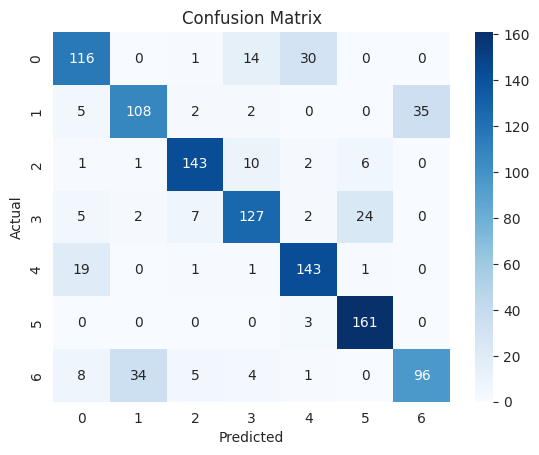

In [162]:
# plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

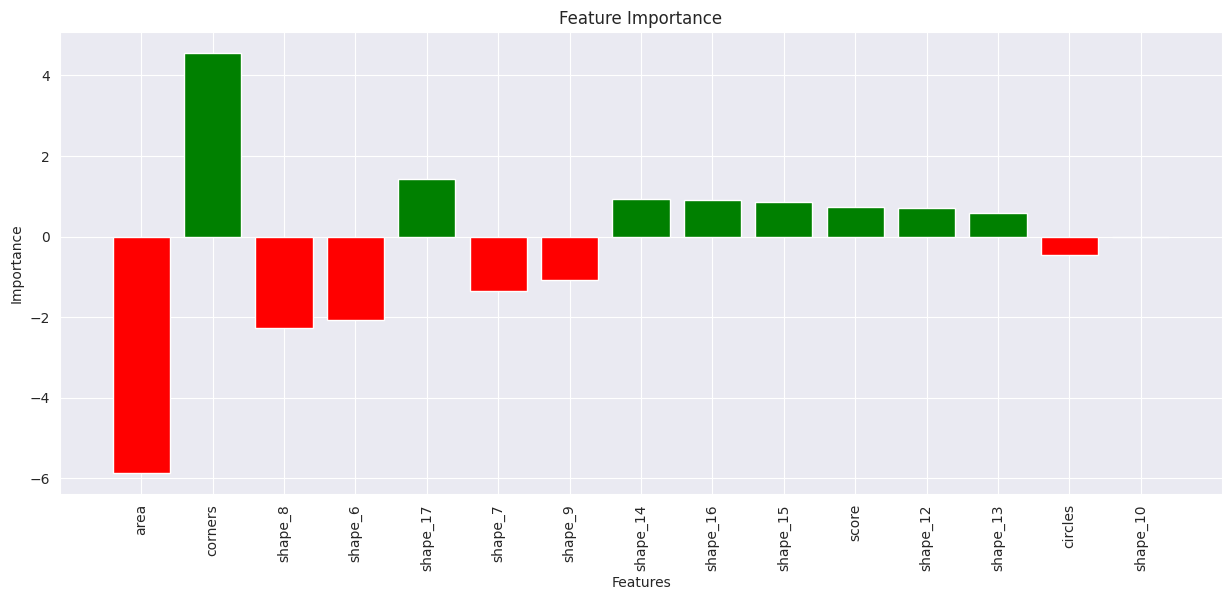

In [163]:
# feature importance
importance = model.coef_[0]

sorted_idx = np.argsort(np.abs(importance))[::-1]

plt.figure(figsize=(15, 6))

for i in range(len(importance)):
    idx = sorted_idx[i]
    plt.bar(i, importance[idx], color='green' if importance[idx] > 0 else 'red')

plt.xticks(range(len(importance)), X_train.columns[sorted_idx], rotation=90)
plt.title('Feature Importance')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.show()

In [164]:
# evaluate model using cross validation
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
print('Cross Validation Accuracy Scores: {}'.format(scores))
print('Average Cross Validation Accuracy Score: {:.4f}'.format(np.mean(scores)))

Cross Validation Accuracy Scores: [0.81362007 0.78614098 0.78349282 0.78229665 0.79186603]
Average Cross Validation Accuracy Score: 0.7915


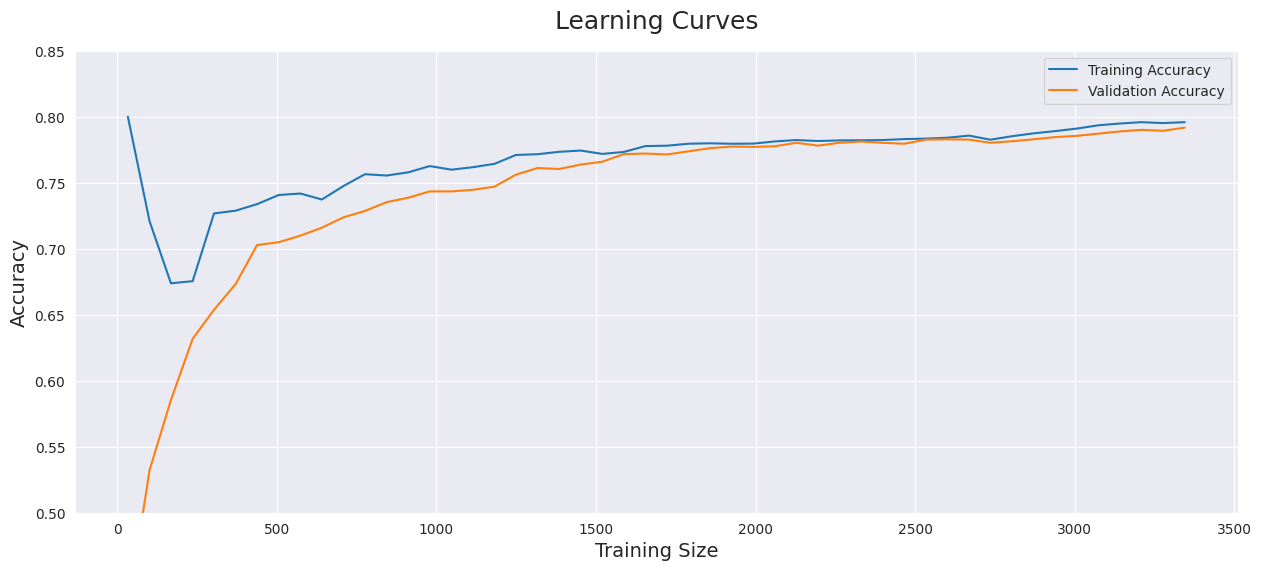

In [165]:
# plot learning curve
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50))

plt.figure(figsize=(15, 6))

plt.plot(train_sizes, train_scores.mean(axis=1), label='Training Accuracy')
plt.plot(train_sizes, test_scores.mean(axis=1), label='Validation Accuracy')

plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Training Size', fontsize=14)
plt.title('Learning Curves', fontsize=18, y=1.03)
plt.legend()
plt.ylim(0.5, 0.85)
plt.show()

### 6.2. K-Nearest Neighbors

In [166]:
# fit model
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier()
model.fit(X_train, y_train)

print('Accuracy Score: ', accuracy_score(y_train, model.predict(X_train)))

Accuracy Score:  0.8663318986131038


In [167]:
# predict test set
y_pred = model.predict(X_test)

print('Accuracy Score: ', accuracy_score(y_test, y_pred))
print('Classification Report: \n', classification_report(y_test, y_pred))

Accuracy Score:  0.8178571428571428
Classification Report: 
               precision    recall  f1-score   support

        2780       0.76      0.82      0.79       161
        3001       0.71      0.62      0.67       152
        4286       0.91      0.91      0.91       163
        6632       0.95      0.87      0.91       167
       43093       0.79      0.83      0.81       165
       54200       0.90      0.98      0.94       164
       99301       0.67      0.66      0.67       148

    accuracy                           0.82      1120
   macro avg       0.81      0.81      0.81      1120
weighted avg       0.82      0.82      0.82      1120


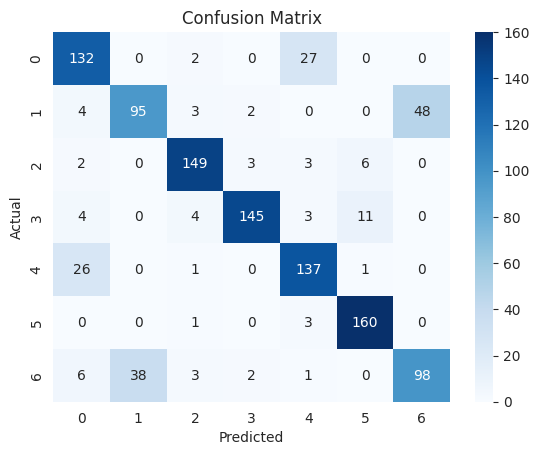

In [168]:
# plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [169]:
# evaluate model using cross validation
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
print('Cross Validation Accuracy Scores: {}'.format(scores))
print('Average Cross Validation Accuracy Score: {:.4f}'.format(np.mean(scores)))

Cross Validation Accuracy Scores: [0.81839904 0.79330944 0.80502392 0.81339713 0.80023923]
Average Cross Validation Accuracy Score: 0.8061


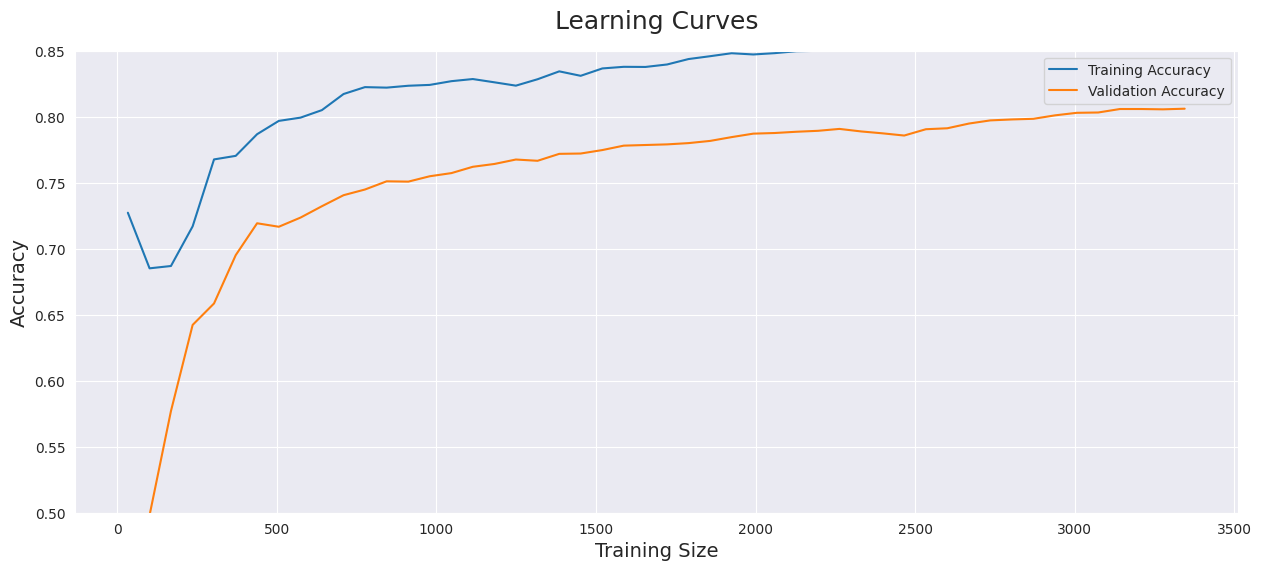

In [170]:
# plot learning curve
train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50))

plt.figure(figsize=(15, 6))

plt.plot(train_sizes, train_scores.mean(axis=1), label='Training Accuracy')
plt.plot(train_sizes, test_scores.mean(axis=1), label='Validation Accuracy')

plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Training Size', fontsize=14)
plt.title('Learning Curves', fontsize=18, y=1.03)
plt.legend()
plt.ylim(0.5, 0.85)
plt.show()

- KNN model has 0.866 accuracy score in training set and 0.817 accuracy score in test set. There is suspicious overfitting problem.
- I will try to find best parameters for KNN model to avoid overfitting problem.

In [171]:
# find best parameters
from sklearn.model_selection import GridSearchCV

param_grid = {'n_neighbors': np.arange(1, 50)}
model = KNeighborsClassifier()

model_cv = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
model_cv.fit(X_train, y_train)

print('Best Parameters: {}'.format(model_cv.best_params_))
print('Best Score: {:.4f}'.format(model_cv.best_score_))

Best Parameters: {'n_neighbors': 3}
Best Score: 0.8144


In [172]:
# fit model with best parameters
model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_train, y_train)

print('Accuracy Score: ', accuracy_score(y_train, model.predict(X_train)))

Accuracy Score:  0.9000478240076518


In [173]:
# predict test set
y_pred = model.predict(X_test)

print('Accuracy Score: ', accuracy_score(y_test, y_pred))
print('Classification Report: \n', classification_report(y_test, y_pred))

Accuracy Score:  0.8267857142857142
Classification Report: 
               precision    recall  f1-score   support

        2780       0.77      0.83      0.80       161
        3001       0.72      0.66      0.69       152
        4286       0.93      0.92      0.92       163
        6632       0.96      0.87      0.92       167
       43093       0.80      0.82      0.81       165
       54200       0.91      0.97      0.94       164
       99301       0.68      0.68      0.68       148

    accuracy                           0.83      1120
   macro avg       0.82      0.82      0.82      1120
weighted avg       0.83      0.83      0.83      1120


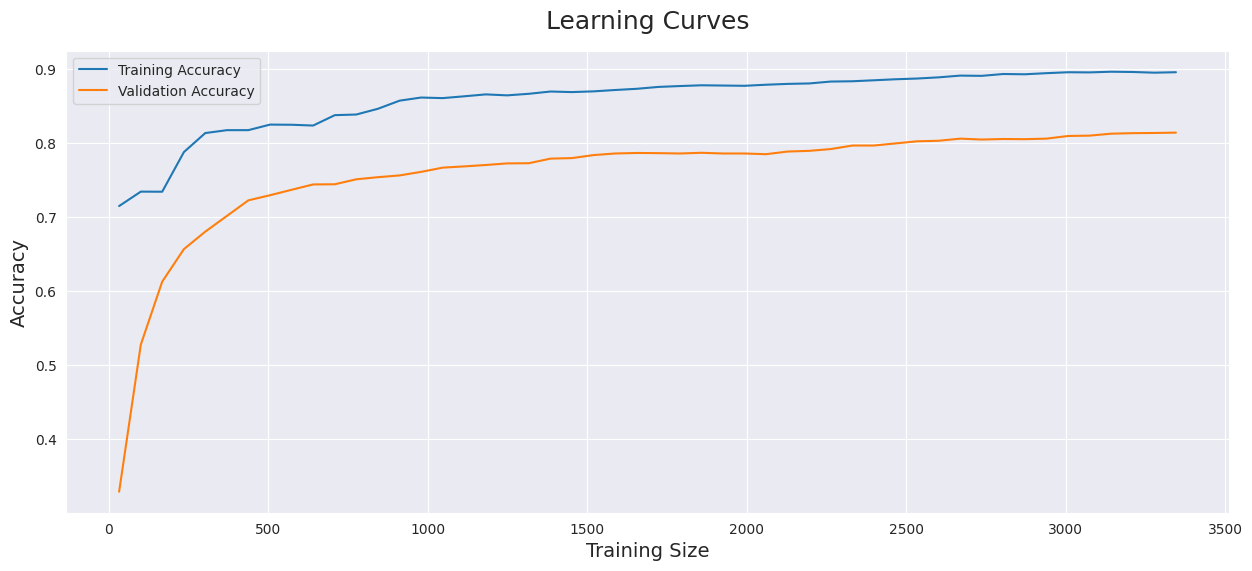

In [174]:
# learning curve
train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50))

plt.figure(figsize=(15, 6))

plt.plot(train_sizes, train_scores.mean(axis=1), label='Training Accuracy')
plt.plot(train_sizes, test_scores.mean(axis=1), label='Validation Accuracy')

plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Training Size', fontsize=14)
plt.title('Learning Curves', fontsize=18, y=1.03)
plt.legend()

plt.show()

- After tuning the parameters, model has 0.90 accuracy score in training set and 0.826 accuracy score in test set. The overfitting problem is getting worse.
- I will try to use ensemble methods to avoid overfitting problem.

In [175]:
# manage over fitting problem
from sklearn.ensemble import BaggingClassifier

model = BaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=3), n_estimators=100, random_state=0)
model.fit(X_train, y_train)

print('Accuracy Score: ', accuracy_score(y_train, model.predict(X_train)))

Accuracy Score:  0.9117647058823529


In [176]:
# predict test set
y_pred = model.predict(X_test)

print('Accuracy Score: ', accuracy_score(y_test, y_pred))
print('Classification Report: \n', classification_report(y_test, y_pred))

Accuracy Score:  0.8303571428571429
Classification Report: 
               precision    recall  f1-score   support

        2780       0.79      0.84      0.81       161
        3001       0.73      0.66      0.69       152
        4286       0.94      0.92      0.93       163
        6632       0.95      0.89      0.92       167
       43093       0.80      0.83      0.82       165
       54200       0.90      0.97      0.94       164
       99301       0.68      0.68      0.68       148

    accuracy                           0.83      1120
   macro avg       0.83      0.83      0.83      1120
weighted avg       0.83      0.83      0.83      1120


- After using ensemble methods, model has 0.91 accuracy score in training set and 0.83 accuracy score in test set.
- Results are better than before but there is still overfitting problem.

## 7. Conclusion

The KNN model seems like a have better test results than Logistic Regression model. However, KNN model has overfitting problem. I tried to avoid overfitting problem by tuning the parameters and using ensemble methods. After tuning the parameters and using ensemble methods, KNN model has 0.91 accuracy score in training set and 0.83 accuracy score in test set. Results are better than before but there is still overfitting problem. I think the reason of the overfitting problem is the small size of the dataset. If I had more data, I could get better results.

I think Logistic Regression model is better than KNN model for this dataset. Because Logistic Regression model has more reliable results than KNN model.

- I used image processing techniques to extract features from images.
- I used 2 different machine learning algorithms to classify the LEGO pieces which are Logistic Regression and KNN algorithms.
- I used 3 different evaluation metrics to evaluate the models which are accuracy score, confusion matrix and classification report.
- I used 2 different methods to avoid overfitting problem which are tuning the parameters and using ensemble methods which are GridSearchCV and BaggingClassifier.
- I used 2 different methods to visualize the results which are confusion matrix and learning curve.

## References

- https://www.kaggle.com/joosthazelzet/lego-brick-images
- https://scikit-image.org/
- https://opencv.org/